In [2]:
import os
import tensorflow as tf
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
import plotly.express as px
from tqdm import tqdm
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

In [3]:
# load the `train32.csv` file
path_to_data = "C:\\Users\\Marko\\Downloads\\archive\\"
train_df32 = pd.read_csv(path_to_data + "train64.csv")

def convert_indication_type(row):
    if row != "good":
        return "damaged"
    else:
        return "good"

def convert_indication_value(row):
    if row != 0:
        return 1
    else:
        return 0

train_df32["indication_type"] = train_df32["indication_type"].apply(convert_indication_type)
train_df32["indication_value"] = train_df32["indication_value"].apply(convert_indication_value)
train_df32.head()

,index,angle,indication_type,indication_value,split
0,48000,0,good,0,train
1,48001,80,good,0,train
2,48002,100,good,0,train
3,48003,100,good,0,train
4,48004,0,good,0,train


In [4]:
train_df32.indication_type.value_counts(normalize=True).round(2)

indication_type
damaged    0.83
good       0.17
Name: proportion, dtype: float64

In [ ]:
# create an object that will take the dataset and produce the dataset in a format required for tensorflow dataset's API
class H5ToStorage:
  def __init__(self, hdf_path, ds_name="train"):
    self.path = hdf_path

    self.classes = []
    with h5py.File(self.path, 'r') as hf:
      for class_ in hf:
        self.classes.append(class_)

    self.name = ds_name

  # a generator to load the (img, class, angle)
  def generate_img_arr(self):
    for class_ in self.classes:
      with h5py.File(self.path, 'r') as hf:
        for angle in hf[class_]:
            for img in hf[class_][f"{angle}"]:
                yield img, class_, angle
  
  # utilize the generator to create new images and load it back to Storage
  def generate_train_dirs(self):
    path = f"./dataset/{self.name}"
    os.makedirs(f"{path}/good/")
    os.makedirs(f"{path}/damaged/")

    gen = self.generate_img_arr()
    metadata = {}
    
    random_flip = tf.keras.layers.RandomFlip("horizontal_and_vertical")
    
    for i, data in enumerate(gen):
        img, label, angle = data
        if label == "good":
          for j in range(4):
            img_path = f"{path}/{label}/{i}_aug{j}.jpeg"
            img = random_flip(tf.expand_dims(np.squeeze(img), axis=2)*255., training=True)
            plt.imsave(img_path, np.squeeze(img), cmap="gray")
        else:
          img_path = f"{path}/damaged/{i}.jpeg"
          
        plt.imsave(img_path, np.squeeze(img)*255., cmap="gray")
        metadata[img_path] = angle
    return metadata

  def generate_test_dirs(self):
    path = f"./dataset/{self.name}"
    os.makedirs(f"{path}/good/")
    os.makedirs(f"{path}/damaged/")

    gen = self.generate_img_arr()
    metadata = {}

    for i, data in enumerate(gen):
        img, label, angle = data
        if label == "good":
          img_path = f"{path}/{label}/{i}.jpeg"
          plt.imsave(img_path, np.squeeze(img)*255., cmap="gray")
        else:
          img_path = f"{path}/damaged/{i}.jpeg"
          plt.imsave(img_path, np.squeeze(img)*255., cmap="gray")

        metadata[img_path] = angle

    return metadata

  def to_storage(self):
    if self.name == "train":
      self.generate_train_dirs()

    elif self.name == "test":
      self.generate_test_dirs()

SyntaxError: invalid syntax. Maybe you meant '==' or ':=' instead of '='? (3771391085.py, line 33)

In [ ]:
# generate train data
train_gen = H5ToStorage(path_to_data + "matchingtDATASET_train_64.h5", "train")
train_dict = train_gen.to_storage()

In [ ]:

# generate test data
test_gen = H5ToStorage(path_to_data + "matchingtDATASET_test_64.h5", "test")
test_dict = test_gen.to_storage()

In [ ]:

# train data & test data paths
test_dir = "dataset/test"
train_dir = "dataset/train"

In [ ]:
# create train data pipeline
IMG_SIZE = (224, 224)
train_data = tf.keras.utils.image_dataset_from_directory(directory=train_dir,
                                                         image_size=IMG_SIZE,
                                                         validation_split=0.2,   # 20 % Validation
                                                         subset="training",
                                                         seed=123,
                                                         color_mode="grayscale",
                                                         label_mode="int",
                                                         batch_size=32)
# classes in train_data
class_names = train_data.class_names
print(f"The class_names are as follows: {class_names}")

train_data = train_data.prefetch(buffer_size=tf.data.AUTOTUNE).\
                        cache()


val_data = tf.keras.utils.image_dataset_from_directory(
    directory=train_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=IMG_SIZE,
    color_mode="grayscale",
    label_mode="int",
    batch_size=64
)

val_data = val_data.prefetch(buffer_size=tf.data.AUTOTUNE).\
                        cache()

# create test data pipeline
test_data = tf.keras.utils.image_dataset_from_directory(directory=test_dir,
                                                        image_size=IMG_SIZE,
                                                        color_mode="grayscale",
                                                        shuffle=False,
                                                        batch_size=32,
                                                        label_mode="int")

test_data = test_data.prefetch(buffer_size=tf.data.AUTOTUNE).\
                      cache() 

NameError: name 'tf' is not defined

In [ ]:

num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(224, 224, 1)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(1, activation='sigmoid')
  ])




In [ ]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


In [ ]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_4 (Rescaling)         │ (None, 224, 224, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 224, 224, 16)   │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 112, 112, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 56, 56, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 56, 56, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │     6,422,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,446,081 (24.59 MB)

 Trainable params: 6,446,081 (24.59 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
epochs=10
history = model.fit(
  train_data,
  validation_data=val_data,
  epochs=epochs
)

Epoch 1/10


 306/1350 ━━━━━━━━━━━━━━━━━━━━ 15:56 917ms/step - accuracy: 0.5898 - loss: 0.7330

: 

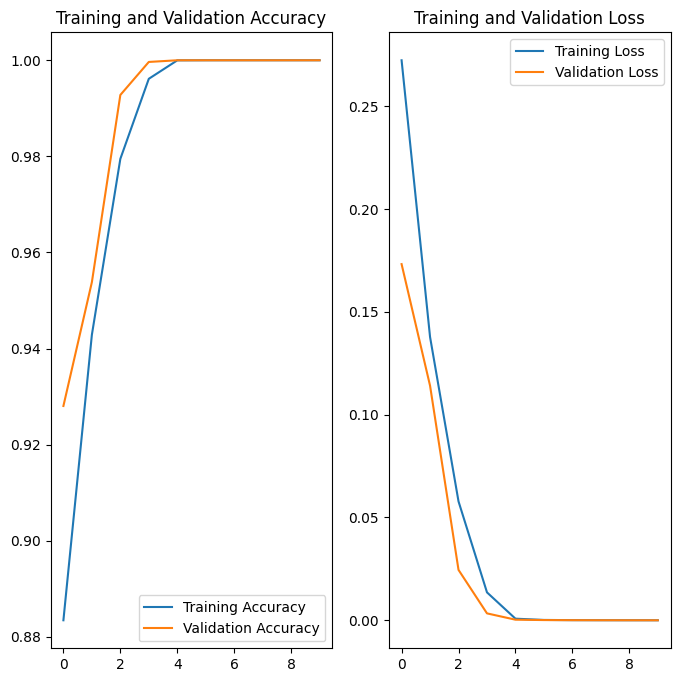

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [ ]:
# y_true from test_data
y_true = np.concatenate([y.numpy() for _, y in test_data])

# predict
y_prob = model.predict(test_data).ravel()     
y_pred = (y_prob >= 0.5).astype(int)

print("F1 (binary):", f1_score(y_true, y_pred, average='binary'))
print(classification_report(y_true, y_pred, target_names=class_names))

563/563 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step
F1 (binary): 0.7056530214424951
              precision    recall  f1-score   support

     damaged       0.94      0.93      0.94     30000
        good       0.69      0.72      0.71      6000

    accuracy                           0.90     36000
   macro avg       0.82      0.83      0.82     36000
weighted avg       0.90      0.90      0.90     36000

